# Wide beam

In [1]:
# import API
import pwpp
from pwpp import *
import pickle
filename='Wide'

In [2]:
# load
infile = open(filename,'rb')
a0, da, alst, dNda_th, dNdaL_th, dNdaLL_th, adistL_x, adistL_y, adist_x, adist_y, Deltalst_th, Deltalst, Deltalst_osiris, Np_th, Np_smpl, Np_osiris = pickle.load(infile)
infile.close()

In [2]:
## parameters
# laser
a0 = 7.3; #[]
lbd = 0.8; #[\mu m]
tau = 30.82; #[fs]
w0 = 2*pi*c/(lbd*1e-6)*hbar/e*1e-9; #[GeV]
W0 = 3.0; #[\mu m]
zR = pi*W0**2/lbd; #[\mu m]
# beam
E0 = 13; #[GeV]
g0 = E0/m; # []
sigmax = 24.4; #[\mu m]
sigmay = 29.6; #[\mu m]
R = (sigmax+sigmay)/2*sqrt(2); #[\mu m]
L = 12.73*4; #[\mu m]
n = tau*c/(lbd*1e-6)*1e-15; #[]
nb = 1e16; #[cm^-3]
nb = nb * 1e-12; #[\mu m^-3]
Nb = nb*(pi*R**2*L); #[]

# osiris data
Deltalst_osiris = [-50.93,-25.465,0,25.465,50.93];
Np_osiris = [8.780593707515441, 125.6552656001146, 394.173264094269, 123.8112039876268, 6.794889959179607];

# Interpolate N+
amin = 2
a0int = np.linspace(amin,a0,200);
Npint = np.array([Np(g0, a, w0, n)[0] for a in a0int])
Npinterp1d = interpolate.interp1d(a0int, Npint)

# analytical distribution
def dNda(a,L):
    """theory"""
    az = a0/sqrt(1+(L/4/zR)**2)
    return np.piecewise(a, [a > az, a <= az], [lambda a: 4*pi*nb*W0**2*zR/a * 1/3/a * sqrt(a0**2-a**2) * ((a0/a)**2+2),
                                               lambda a: 4*pi*nb*W0**2*zR/a * L/4/zR * (1+(L/4/zR)**2/3) ])

# Distribution

In [4]:
Nsmpl = int(1e7);
zmax = +L/4 ; #[\mu m]
zmin = zmax-L/2; #[\mu m]
# coordinate data (constant density)
zdist = (zmax-zmin)*rng.random(Nsmpl) + zmin; #[\mu m]
zdistL = L*5/2*rng.random(Nsmpl) - L*5/4; #[\mu m]
xdist = sigmax*rng.standard_normal(Nsmpl) #[\mu m]
ydist = sigmay*rng.standard_normal(Nsmpl) #[\mu m]

# calculate a
adim = 50; #[]
nbins = 20; #[]
alst = np.linspace(0.01*a0,0.999*a0,adim); #[]
abins = np.linspace(0.01*a0,0.999*a0,nbins); #[]
da = abins[1]-abins[0]; #[]
# get histograms
adist = gauss3D(zdist,xdist,ydist,a0,W0,lbd);
adistL = gauss3D(zdistL,xdist,ydist,a0,W0,lbd);
adist_y,adist_x = np.histogram(adist,abins)
adistL_y,adistL_x = np.histogram(adistL,abins)

# normalize to Nb
adist_y, adist_x = adist_y*Nb/Nsmpl, arraycenter(adist_x)
adistL_y, adistL_x = adistL_y*Nb/Nsmpl, arraycenter(adistL_x)
# analytical distribution
dNda_th = dNda(alst,L);
dNdaL_th = dNda(alst,L*5);
dNdaLL_th = dNda(alst,L*200);

# Displacement

In [5]:
# sampling method
Nsmpl = int(1e5);
zmax = +L/4 ; #[\mu m]
zmin = zmax-L/2; #[\mu m]
# coordinate data
zdist = (zmax-zmin)*rng.random(Nsmpl) + zmin; #[\mu m]
xdist = sigmax*rng.standard_normal(Nsmpl) #[\mu m]
ydist = sigmay*rng.standard_normal(Nsmpl) #[\mu m]

Deltalst = np.linspace(0,+1.5*50.93,7);
dz = (Deltalst[1]-Deltalst[0]); #[\mu m]
Np_smpl = np.zeros(len(Deltalst));

for i in trange(len(Deltalst)):
    Delta = Deltalst[i];
            
    # sampling
    adist = gauss3D(zdist, xdist, ydist, a0, W0, lbd)
    adist2 = adist[adist > amin]
    dNp = np.array([Npinterp1d(a) for a in adist2 ])
    Np_smpl[i] = np.sum( dNp ) * Nb/Nsmpl
            
    # update z
    zdist = zdist + dz

100%|██████████| 7/7 [00:00<00:00, 16.90it/s]


In [30]:
# analytical approximation
Deltalst_th = np.linspace(0,+1.5*50.93);
Np_th = np.zeros(len(Deltalst_th));
Np_th = quad(lambda a: dNda(a,L) * Np(g0,a,w0,n) ,amin,0.999*a0)[0] * exp(-(Deltalst_th/(L/2))**2);

In [8]:
# save
outfile = open(filename,'wb')
pickle.dump([a0, da, alst, dNda_th, dNdaL_th, dNdaLL_th, adistL_x, adistL_y, adist_x, adist_y, Deltalst_th, Deltalst, Deltalst_osiris, Np_th, Np_smpl, Np_osiris],outfile)
outfile.close()

# Plot

In [ ]:
plt.style.use("style.txt")
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,3.5))

plt.subplot(121)
plt.plot(alst, dNdaLL_th*da, 'k-', label='Theory');
plt.plot(alst, dNdaL_th*da, '--');
plt.plot(alst, dNda_th*da, '--');
plt.plot(adistL_x, adistL_y*4, '.', label='Beam');
plt.plot(adist_x, adist_y, '.', label='Beamlet');
plt.yscale('log')
plt.xlabel(r'$a_{0,\mathrm{eff}}$')
plt.ylabel(r'$\frac{dN_b}{da_{0,\mathrm{eff}}} \left[ \frac{n_b}{10^{16}~ \mathrm{cm}^{-3}} \right]$',labelpad=15)
plt.xlim([0,a0])
plt.ylim(0.5e5,1e10)
plt.yticks([1e5,1e7,1e9])
plt.legend(frameon=False)
plt.tick_params(which='both',axis="y",direction="in", labelleft=True, labelright=False, left=True, right=True)
plt.tick_params(which='both',axis="x",direction="in", labeltop=False, labelbottom=True, top=True, bottom=True)
axes[0].set_aspect(aspect=4/3)

plt.subplot(122)
plt.plot(Deltalst_th,Np_th,'k-',label='Theory');
plt.plot(Deltalst,Np_smpl,'.',label='Sampling');
plt.plot(Deltalst_osiris,Np_osiris,'o',label='Simulation',fillstyle='none');
plt.xlabel(r'$\Delta_\parallel[\mu \mathrm{m}]$')
plt.ylabel(r'$N_+ \left[ \frac{n_b}{10^{16}~ \mathrm{cm}^{-3}} \right]$',labelpad=15)
plt.legend(frameon=False)
plt.xlim([-1,60])
plt.ylim([-10,600])
plt.yticks([0,200,400,600])
axes[1].set_aspect(aspect=4/3)

plt.tight_layout()
#plt.savefig('3D.pdf')
plt.show()

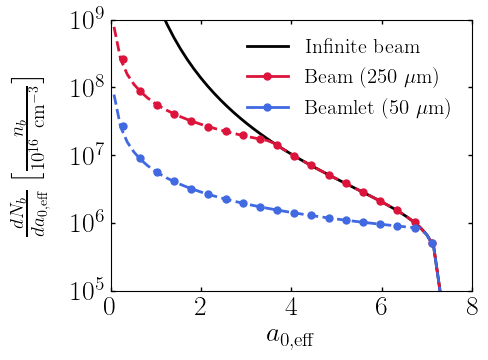

In [26]:
plt.style.use("style.txt")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

plt.plot(alst, dNdaLL_th*da, 'k-', label='Infinite beam');
plt.plot(alst, dNdaL_th*da, '--', color='crimson');
plt.plot(alst, dNda_th*da, '--', color='royalblue');
plt.plot(adistL_x, adistL_y*5, '.', color='crimson');
plt.plot(adistL_x, adistL_y*1e-10, '.-', color='crimson', label=r'Beam ($250 ~\mu$m)');
plt.plot(adist_x, adist_y, '.', color='royalblue');
plt.plot(adist_x, adist_y*1e-10, '.-', color='royalblue', label=r'Beamlet ($50 ~\mu$m)');
plt.yscale('log')
plt.xlabel(r'$a_{0,\mathrm{eff}}$')
plt.ylabel(r'$\frac{dN_b}{da_{0,\mathrm{eff}}} \left[ \frac{n_b}{10^{16}~ \mathrm{cm}^{-3}} \right]$',labelpad=15)
plt.legend(frameon=False,)
plt.tick_params(which='both',axis="y",direction="in", labelleft=True, labelright=False, left=True, right=True)
plt.tick_params(which='both',axis="x",direction="in", labeltop=False, labelbottom=True, top=True, bottom=True)
plt.xlim([0,7.3])
plt.ylim(1e5,1e9)
plt.xticks([0,2,4,6,8])
plt.yticks([1e5,1e6,1e7,1e8,1e9])
# aspect
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()
axesratio = (np.log10(ymax)-np.log10(ymin))/(xmax-xmin)
axes.set_aspect(aspect=3/4/axesratio)
# final
plt.tight_layout()
plt.savefig('3D_a.pdf')
plt.show()

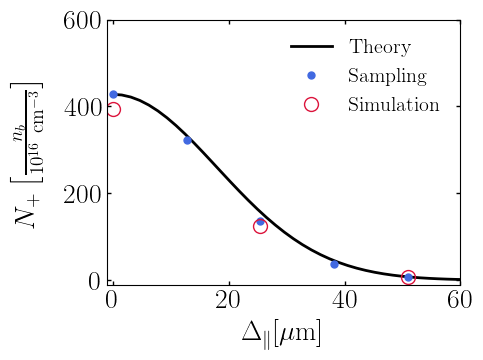

In [38]:
plt.style.use("style.txt")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

plt.plot(Deltalst_th,Np_th,'k-',label='Theory');
plt.plot(Deltalst,Np_smpl,'.',label='Sampling');
plt.plot(Deltalst_osiris,Np_osiris,'o',label='Simulation',fillstyle='none');
plt.xlabel(r'$\Delta_\parallel[\mu \mathrm{m}]$')
plt.ylabel(r'$N_+ \left[ \frac{n_b}{10^{16}~ \mathrm{cm}^{-3}} \right]$',labelpad=15)
plt.legend(frameon=False)
plt.tick_params(which='both',axis="y",direction="in", labelleft=True, labelright=False, left=True, right=True)
plt.tick_params(which='both',axis="x",direction="in", labeltop=False, labelbottom=True, top=True, bottom=True)
plt.xlim([-1,60])
plt.ylim([-10,600])
plt.yticks([0,200,400,600])
# aspect
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()
axesratio = (ymax-ymin)/(xmax-xmin)
axes.set_aspect(aspect=3/4/axesratio)
# final
plt.tight_layout()
#plt.savefig('3D_b.pdf')
plt.show()